## Librerías

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-04-22 02:39:14.631217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 02:39:14.631247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 02:39:14.634485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 02:39:14.834752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-04-22 02:39:18.383810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 02:39:18.441377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 02:39:18.441529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Datos

In [3]:
## Function to get contours and features
''''
def get_contours_and_features(binary_map):
    # get binary map
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    # get contours from binary map
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # get features from contours
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features
'''
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'aspect_ratio': np.float32(w)/h, 
            'extent': np.float32(cv2.contourArea(contour))/rect_area,
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features


# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores
'''
def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros##
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes
'''

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')
        
        ## Calcular el aspect ratio de los poros
        aspect_ratio = get_item(contour_features, key='aspect_ratio')

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro), np.mean(eq_diameter), np.mean(aspect_ratio), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

# function to associate geometric atributes with images

def normalize_geometric_properties(dataset):

    ## Listas para guardar propiedades
    areas = []
    perimetros = []
    intersticios = []
    poros = []

    for i in range(len(dataset)):    
        
        ## obtener ruta de la imagen
        mask_route = dataset['route_mask'].to_numpy()[i]
        ## obtener imagen binaria
        mask = get_binary_image([mask_route])
        ## capturar propiedades
        atrs = get_geometric_atributes(mask)[0]

        ## agregar a listas las propiedades
        areas.append(atrs[0])
        perimetros.append(atrs[1])
        intersticios.append(atrs[2])
        poros.append(atrs[3])

    ## normalizar datos
        
    # normalizar area
    min_area = np.min(areas)
    max_area = np.max(areas)
    areas_norm = (areas - min_area) / (max_area - min_area)

    # normailizar perimetro
    min_perimetro = np.min(perimetros)
    max_perimetro = np.max(perimetros)
    perimetros_norm = (perimetros - min_perimetro) / (max_perimetro - min_perimetro)

    #normalizar intersticio
    min_intersticio = np.min(intersticios)
    max_intersticio = np.max(intersticios)
    intersticios_norm = (intersticios - min_intersticio) / (max_intersticio - min_intersticio)

    #normalizar poros
    min_poros = np.min(poros)
    max_poros = np.max(poros)
    poros_norm = (poros - min_poros) / (max_poros - min_poros)


    dataset['area'] = areas_norm
    dataset['perimetro'] = perimetros_norm
    dataset['intersticio'] = intersticios_norm
    dataset['poros'] = poros_norm


    return dataset, [min_area, min_perimetro, min_intersticio, min_poros], [max_area, max_perimetro, max_intersticio, max_poros]


## desnormalizar datos
def de_normalize_value(value, min_value, max_value):
    return (value * (max_value - min_value)) + min_value

## Reorganizar atributos geométricos
def organize_geometric_atributes(dataset):
    attributes = []
    for i in range(len(dataset)):
        attributes.append([dataset['area'].to_numpy()[i],dataset['perimetro'].to_numpy()[i],dataset['intersticio'].to_numpy()[i],dataset['poros'].to_numpy()[i]])

    return attributes

def split_dataset(routes_dataset):
    ## Establecer el porcentaje de separación
    thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
    thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
    thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

    ## Separar por clases para entrenamiento
    train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
    train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
    train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

    ## tomar las demás imágenes para test
    test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
    test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
    test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


    ## Constuir un solo dataset de training
    train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

    ## Construir un solo dataset de test
    test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

    ## Cantidad de muestras por clase
    print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
    print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
    print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

    return train_df, test_df


def create_dataset(buffer,dataset): 
  ## Get file names
  file_names = dataset['route_image'].to_numpy()
  ## Get labels
  labels = dataset['label'].to_numpy()
  ## Get geometric atributes from binary images
  attributes = organize_geometric_atributes(dataset)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

In [4]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

dataset, mins, maxs = normalize_geometric_properties(routes_dataset)

train_df, test_df = split_dataset(dataset)

dataset = create_dataset(16,train_df)

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


2024-04-22 02:39:19.247707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 02:39:19.247979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 02:39:19.248164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


[0.35338443 0.40625626 0.48268343 0.47906315]
b'0'


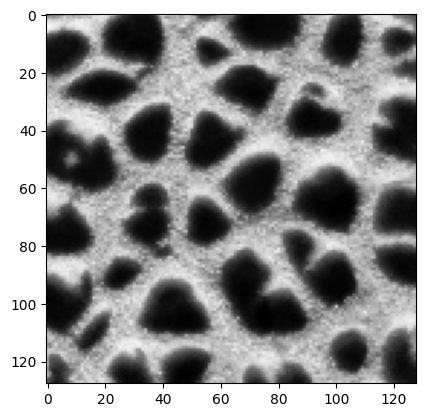

In [5]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]
    #d = i[3]

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')
#plt.imshow(d[n],cmap='gray')
plt.show()

In [6]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].route_image
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (183, 128, 128, 1)  test -> (183,)


In [7]:
x_test_secas = np.array(X_test_secas)
x_test_secas= x_test_secas.astype('float32')
 
#y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

Number of images in x_test (183, 128, 128, 1) y_test:  (183,)


In [8]:
x_train = []
y_train_ten = []
for data,label,attributes in dataset.batch(8):
    x_train.extend(data[:].numpy())
    y_train_ten.extend(label)   

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train= []
for i in y_train_ten:
    y_train.append(str(int(i)))

print(np.shape(x_train),np.shape(y_train))

(740, 128, 128, 1) (740,)


## Modelo

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
encoder = keras.models.load_model('Models/weakly_avgfeatures_GVAE_encoder_DRY_6_32.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models/weakly_avgfeatures_GVAE_decoder_DRY_6_32.h5', custom_objects={'Sampling':Sampling})

## Visualización embebidos

In [11]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 8
dmy = 4

In [12]:
data_train = x_train
data_test = x_test_secas

label_train = y_train
label_test = y_test_secas

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-04-22 02:40:15.084341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-22 02:40:15.337995: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-22 02:40:15.338047: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-22 02:40:15.338071: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

24/24 [==============================] - 3s 82ms/step
Shape_embs:  (3, 740, 32)
6/6 [==============================] - 1s 233ms/step
Shape_embs:  (3, 183, 32)


In [13]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds))

24/24 [==============================] - 1s 10ms/step
(740, 128, 128, 1) (3, 740, 32)


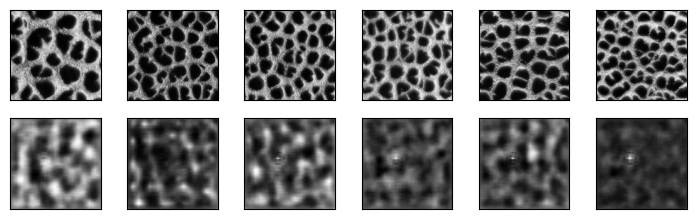

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)    
    plt.imshow(data_train[i].reshape(128,128,1))
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)    
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()
plt.tight_layout()

In [15]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 23ms/step
(183, 128, 128, 1) (3, 183, 32)


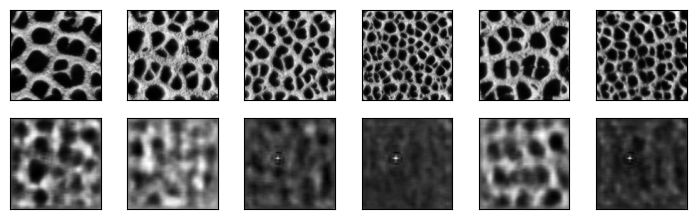

In [16]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)       
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

### PCA

In [17]:
labels_text_test = pd.DataFrame(label_test).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

(183, 1)

### 2 dimensiones

In [18]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(183, 2)

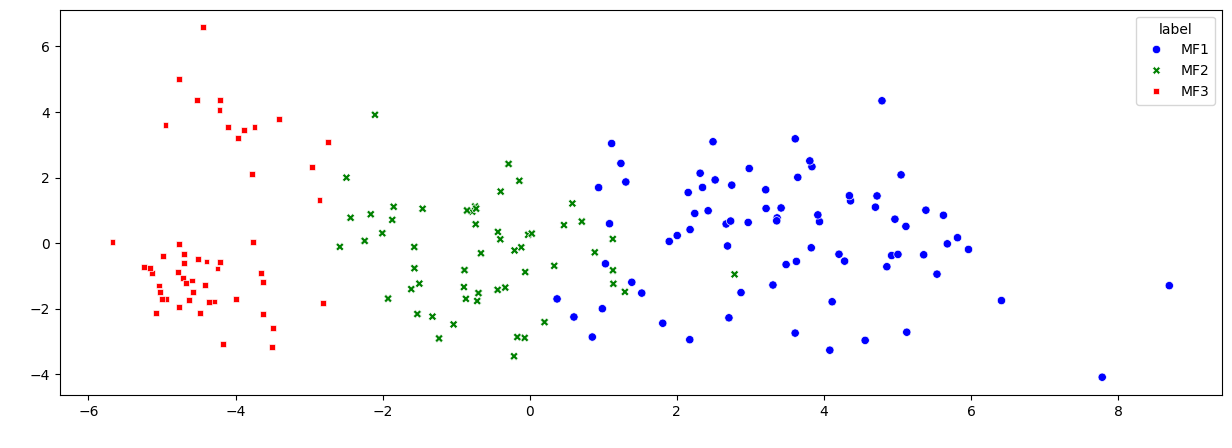

In [19]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

### 3 Dimensiones

In [20]:
pca_data_test_3D = PCA(n_components=3)
PCA_3dim_test = pca_data_test_3D.fit_transform(encoder_embds_test[D])
PCA_3dim_test.shape

(183, 3)

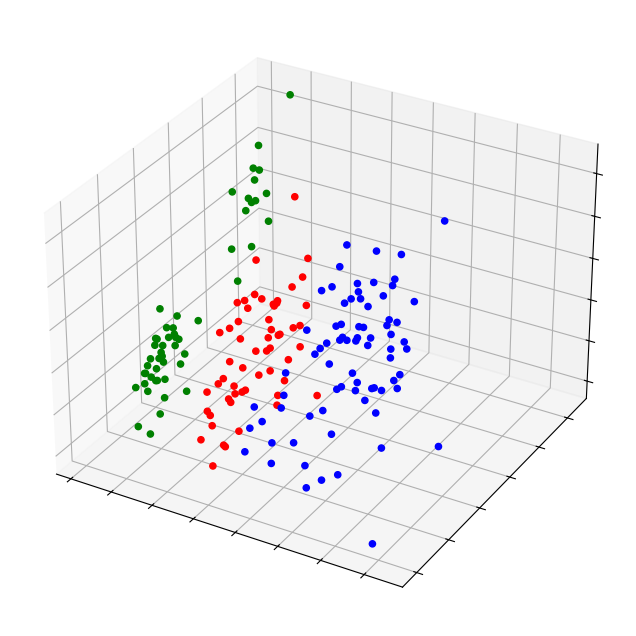

In [21]:
from matplotlib.colors import ListedColormap
data_img_pca_test_3D = pd.DataFrame()                 
data_img_pca_test_3D['x'] = PCA_3dim_test[:,0]
data_img_pca_test_3D['y'] = PCA_3dim_test[:,1]
data_img_pca_test_3D['Z'] = PCA_3dim_test[:,1]
data_img_pca_test_3D['label'] = pd.DataFrame(labels_text_test)

# 3D scatterplot using matplotlib
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

x = data_img_pca_test_3D['x']
y = data_img_pca_test_3D['y']
z = data_img_pca_test_3D['Z']
mycmap = ListedColormap(["blue", "red", "green"])
ax.scatter(x, y, z, c =  data_img_pca_test_3D['label'].replace({'MF1': 0, 'MF2': 1,'MF3': 2}), marker='o', cmap=mycmap, s=20, alpha=1)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_zlabel(' ')
ax.grid(True)
plt.show()


## Distancia entre embebidos

In [22]:
### Tipos de distancias entre dos puntos

## Distancia euclidiana
def euclidean_distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

## Distancia de Manhattan
def manhattan_distance(x,y):
    return np.sum(np.abs(x-y))

## Distancia de hausdorff
def hausdorff_distance(x,y):
    return np.max([np.max([np.min([np.abs(i-j) for j in y]) for i in x]),np.max([np.min([np.abs(i-j) for i in x]) for j in y])])

In [23]:
embebidos = pd.DataFrame()
embebidos['vectores'] = list(encoder_embds_test[D])
embebidos['etiquetas'] = labels_text_test

## Separar los embebidos por clases
embebidos_A = embebidos[embebidos.etiquetas == 'MF1']
embebidos_B = embebidos[embebidos.etiquetas == 'MF2']
embebidos_C = embebidos[embebidos.etiquetas == 'MF3']
## Centroide de cada clase
centroid_A = np.mean(embebidos_A.vectores)
centroid_B = np.mean(embebidos_B.vectores)
centroid_C = np.mean(embebidos_C.vectores)

#### WSS (Distancia euclidiana)

Distancia media de los puntos de la clase A al centroide:  4.965432
Distancia media de los puntos de la clase B al centroide:  3.270095
Distancia media de los puntos de la clase C al centroide:  2.887407
Varianza de las distancias de los puntos de la clase A al centroide:  0.90075684
Varianza de las distancias de los puntos de la clase B al centroide:  0.47025132
Varianza de las distancias de los puntos de la clase C al centroide:  1.1046735
Distancia media de los puntos de la clase A al centroide de la clase B:  7.1841555
Distancia media de los puntos de la clase A al centroide de la clase C:  9.62032
Distancia media de los puntos de la clase B al centroide de la clase A:  7.1841555
Distancia media de los puntos de la clase B al centroide de la clase C:  5.7449923
Distancia media de los puntos de la clase C al centroide de la clase A:  9.620319
Distancia media de los puntos de la clase C al centroide de la clase B:  5.7449923


<Axes: ylabel='class'>

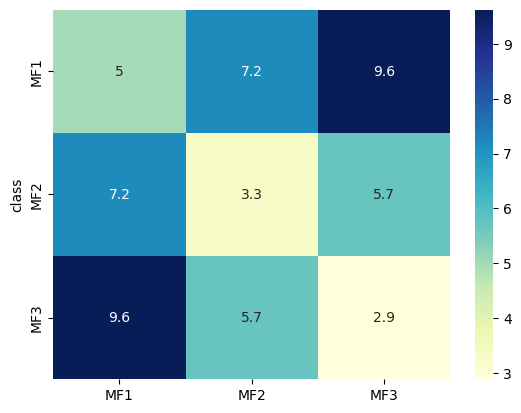

In [24]:
## Distancias de cada punto al centroide
distancias_A = []
for i in embebidos_A.vectores:
    distancias_A.append(euclidean_distance(i,centroid_A))

distancias_B = []
for i in embebidos_B.vectores:
    distancias_B.append(euclidean_distance(i,centroid_B))

distancias_C = []
for i in embebidos_C.vectores:
    distancias_C.append(euclidean_distance(i,centroid_C))

## Distancia media de todos los puntos al centroide
distancias_A_mean = np.mean(distancias_A)
distancias_B_mean = np.mean(distancias_B)
distancias_C_mean = np.mean(distancias_C)

## Varianza de las distancias
varianza_A = np.var(distancias_A)
varianza_B = np.var(distancias_B)
varianza_C = np.var(distancias_C)

print('Distancia media de los puntos de la clase A al centroide: ',distancias_A_mean)
print('Distancia media de los puntos de la clase B al centroide: ',distancias_B_mean)
print('Distancia media de los puntos de la clase C al centroide: ',distancias_C_mean)

print('Varianza de las distancias de los puntos de la clase A al centroide: ',varianza_A)
print('Varianza de las distancias de los puntos de la clase B al centroide: ',varianza_B)
print('Varianza de las distancias de los puntos de la clase C al centroide: ',varianza_C)


## calcular la distancias entre clusters todos contra todos
def allvsall(A,B):
    distancias = []
    for i in A:
        for j in B:
            if euclidean_distance(i,j) != 0:
                distancias.append(euclidean_distance(i,j))
    return np.mean(distancias)

distancias_A_B = allvsall(embebidos_A.vectores,embebidos_B.vectores)
distancias_A_C = allvsall(embebidos_A.vectores,embebidos_C.vectores)
distancias_B_A = allvsall(embebidos_B.vectores,embebidos_A.vectores)
distancias_B_C = allvsall(embebidos_B.vectores,embebidos_C.vectores)
distancias_C_A = allvsall(embebidos_C.vectores,embebidos_A.vectores)
distancias_C_B = allvsall(embebidos_C.vectores,embebidos_B.vectores)


print('Distancia media de los puntos de la clase A al centroide de la clase B: ',distancias_A_B)
print('Distancia media de los puntos de la clase A al centroide de la clase C: ',distancias_A_C)
print('Distancia media de los puntos de la clase B al centroide de la clase A: ',distancias_B_A)
print('Distancia media de los puntos de la clase B al centroide de la clase C: ',distancias_B_C)
print('Distancia media de los puntos de la clase C al centroide de la clase A: ',distancias_C_A)
print('Distancia media de los puntos de la clase C al centroide de la clase B: ',distancias_C_B)

# tabla de distancias entre centroides de las clases
distancias_centroides = pd.DataFrame()
distancias_centroides['class'] = ['MF1','MF2','MF3']
distancias_centroides['MF1'] = [distancias_A_mean,distancias_A_B,distancias_A_C]
distancias_centroides['MF2'] = [distancias_B_A,distancias_B_mean,distancias_B_C]
distancias_centroides['MF3'] = [distancias_C_A,distancias_C_B,distancias_C_mean]
distancias_centroides

del distancias_C_B, distancias_C_A, distancias_B_C, distancias_B_A, distancias_A_C, distancias_A_B
del distancias_C, distancias_B, distancias_A

data = sns.heatmap(distancias_centroides.set_index('class'), annot=True, cmap="YlGnBu")
data

#### Davies-Bouldin Index

computes the average ratio of within-cluster scatter to between-cluster separation, ranging from 0 to infinity (lower values indicate better clustering)

In [25]:
## https://www.geeksforgeeks.org/davies-bouldin-index/
from sklearn.datasets import load_wine
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
 
db_index = davies_bouldin_score(encoder_embds_test[D], np.array(labels_text_test.values.ravel()))

data_pca = []
for i in range(len(data_img_pca_test)):
    data_pca.append([data_img_pca_test.x[i],data_img_pca_test.y[i]])

db_index_pca = davies_bouldin_score(data_pca, labels_text_test.values.ravel())

db_index_pca

print('Índice de Davies-Bouldin: ',db_index)
print('Índice de Davies-Bouldin PCA: ',db_index_pca)

Índice de Davies-Bouldin:  1.86677046199151
Índice de Davies-Bouldin PCA:  0.994515147972408


#### Silhouette coefficient 
calculates the average similarity of each data point to its own cluster and the average dissimilarity to the nearest cluster. It ranges from -1 to 1, with higher values indicating better clustering

In [26]:
from sklearn.metrics import silhouette_score
SC = silhouette_score(encoder_embds_test[D], np.array(labels_text_test.values.ravel()))
SC_pca = silhouette_score(data_pca, np.array(labels_text_test.values.ravel()))

print('Silhouette Coefficient: ',SC)
print('Silhouette Coefficient PCA: ',SC_pca)

Silhouette Coefficient:  0.1355275
Silhouette Coefficient PCA:  0.360233


#### Calinski-Harabasz index
compares the variance of the data within the clusters to the variance of the data between the clusters, ranging from 0 to infinity (higher values indicate better clustering).

In [27]:
from sklearn.metrics import calinski_harabasz_score
CH = calinski_harabasz_score(encoder_embds_test[D], np.array(labels_text_test.values.ravel()))
CH_pca = calinski_harabasz_score(data_pca, np.array(labels_text_test.values.ravel()))

print('Calinski-Harabasz Index: ',CH)
print('Calinski-Harabasz Index PCA: ',CH_pca)

Calinski-Harabasz Index:  56.7838889482704
Calinski-Harabasz Index PCA:  179.1041697508953
